# Decade IT trends based on HN

**Hypothesis:** keywords form HN front pages titles from different days should show trends from the past decade.

In [1]:
import sys
from datetime import timedelta, datetime
import time
import requests
import json
import pandas as pd
import numpy as np
import spacy
from lxml import etree
import urllib.parse

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
nlp = spacy.load("en_core_web_lg")

## Fetching the data

The dataset will consist of HN front pages from [2010-01-01](https://news.ycombinator.com/front?day=2010-01-01) to [2019-12-32](https://news.ycombinator.com/front?day=2019-12-32).

In [15]:
def fetch_day_html(day):
    response = requests.get('https://news.ycombinator.com/front',
                            params={'day': day.strftime("%Y-%m-%d")})
    return response.text

In [23]:
_fetched_cache = {}

In [21]:
def fetch_decade_by_day_html():
    current = datetime(2010, 1, 1)
    end = datetime(2019, 12, 31)
    while current <= end:
        sys.stdout.write(f'\rfetching {current}')
        if current not in _fetched_cache:
            _fetched_cache[current] = fetch_day_html(current)
        yield _fetched_cache[current]
        current += timedelta(days=1)

In [27]:
decade_by_day = [*fetch_decade_by_day_html()]

fetching 2012-06-25 00:00:00

fetching 2019-12-31 00:00:00

In [29]:
len(decade_by_day)

3652

In [30]:
# json.dump(decade_by_day, open('../hn_by_day.json', 'w'))

In [4]:
# decade_by_day = json.load(open('../hn_by_day.json', 'r'))

## Parsing the pages
The parsed result will contain creation date, rank, title and title tokens from HN posts.

In [73]:
def get_entries(day):
    html = decade_by_day[day]
    tree = etree.HTML(html)
    entries = tree.findall('.//table[@class="itemlist"]/tr[@class="athing"]')
    sys.stdout.write('\rparse ' + str(datetime(2010, 1, 1) + timedelta(days=day)))
    for entry in entries:
        rank = int(entry.find('.//span[@class="rank"]').text.replace('.', ''))
        link = entry.find('.//a[@class="storylink"]')
        yield (datetime(2010, 1, 1) + timedelta(days=day), rank, link.text)
    if not entries:
        print("\nNo data", day, datetime(2010, 1, 1) + timedelta(days=day))

In [74]:
hn_df = pd.DataFrame([entry for day in range(len(decade_by_day)) for entry in get_entries(day)],
                     columns=('created', 'rank', 'title'))

parse 2014-01-06 00:00:00
No data 1466 2014-01-06 00:00:00
parse 2019-12-31 00:00:00

Actually no data for [2014-01-06](https://news.ycombinator.com/front?day=2014-01-06).

In [75]:
hn_df

,created,rank,title
0,2010-01-01,1,Ask HN: Great books you read in 2009?
1,2010-01-01,2,Ask HN: Review my app: Search expired/availabl...
2,2010-01-01,3,Beyond PageRank: Learning with Content and Net...
3,2010-01-01,4,Ask HN: A New Decade. Any Predictions?
4,2010-01-01,5,Paul Buchheit: Tablet thoughts
...,...,...,...
109525,2019-12-31,26,The Four-Inch Flight – A Lesson from History
109526,2019-12-31,27,Semigroup Resonance FizzBuzz
109527,2019-12-31,28,On Technical Writing
109528,2019-12-31,29,Interview with Rui Pinto of Football Leaks


In [76]:
#  hn_df.to_json('../hn_df.json')

In [5]:
hn_df = pd.read_json('../hn_df.json')

In [6]:
hn_df['tokens'] = hn_df.title.apply(nlp)

In [20]:
hn_df['created'] = hn_df.created.apply(lambda t: datetime.fromtimestamp(t / 1000))

In [21]:
hn_df

,created,rank,title,tokens
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,"(Ask, HN, :, Great, books, you, read, in, 2009..."
1,2010-01-01 01:00:00,2,Ask HN: Review my app: Search expired/availabl...,"(Ask, HN, :, Review, my, app, :, Search, expir..."
2,2010-01-01 01:00:00,3,Beyond PageRank: Learning with Content and Net...,"(Beyond, PageRank, :, Learning, with, Content,..."
3,2010-01-01 01:00:00,4,Ask HN: A New Decade. Any Predictions?,"(Ask, HN, :, A, New, Decade, ., Any, Predictio..."
4,2010-01-01 01:00:00,5,Paul Buchheit: Tablet thoughts,"(Paul, Buchheit, :, Tablet, thoughts)"
...,...,...,...,...
109525,2019-12-31 01:00:00,26,The Four-Inch Flight – A Lesson from History,"(The, Four, -, Inch, Flight, –, A, Lesson, fro..."
109526,2019-12-31 01:00:00,27,Semigroup Resonance FizzBuzz,"(Semigroup, Resonance, FizzBuzz)"
109527,2019-12-31 01:00:00,28,On Technical Writing,"(On, Technical, Writing)"
109528,2019-12-31 01:00:00,29,Interview with Rui Pinto of Football Leaks,"(Interview, with, Rui, Pinto, of, Football, Le..."


## Adventure

In the adventure single PROPN token is treated as a keyword.

In [22]:
tokens_df = hn_df \
    .explode('tokens') \
    .rename(columns={'tokens': 'token'})
tokens_df['keyword'] = tokens_df.token.apply(lambda x: str(x).lower())

In [23]:
tokens_df

,created,rank,title,token,keyword
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,Ask,ask
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,HN,hn
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,:,:
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,Great,great
0,2010-01-01 01:00:00,1,Ask HN: Great books you read in 2009?,books,books
...,...,...,...,...,...
109528,2019-12-31 01:00:00,29,Interview with Rui Pinto of Football Leaks,Football,football
109528,2019-12-31 01:00:00,29,Interview with Rui Pinto of Football Leaks,Leaks,leaks
109529,2019-12-31 01:00:00,30,Records on Bone,Records,records
109529,2019-12-31 01:00:00,30,Records on Bone,on,on


In [24]:
tokens_df \
    .groupby('keyword')\
    .count() \
    ['rank'] \
    .reset_index() \
    .sort_values('rank', ascending=False)

,keyword,rank
42481,the,25902
3286,:,19792
3315,a,19274
42975,to,18253
30138,of,15369
...,...,...
21375,hunker,1
21373,hungriest,1
21372,hunger,1
21366,hunchentoot,1


In [25]:
keywords_df = tokens_df \
    [tokens_df.token.apply(lambda token: token.pos_ == 'PROPN')] \
    .reset_index(drop=True)

In [26]:
keywords_df \
    .groupby('keyword')\
    .count() \
    ['rank'] \
    .reset_index() \
    .sort_values('rank', ascending=False) \
    .head(10)

,keyword,rank
11791,hn,5738
10606,google,3478
23672,show,3332
8719,facebook,1470
17755,new,1469
20971,python,1462
1351,apple,1454
19399,pdf,1204
13328,javascript,1124
14923,linux,1108


## Sanity checks

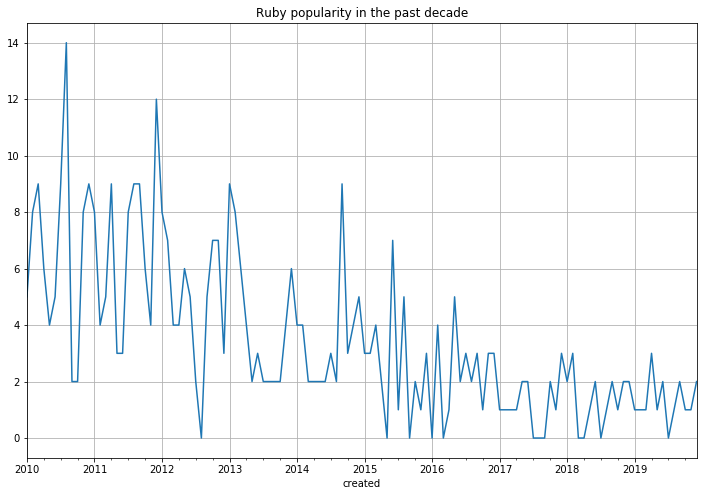

In [27]:
keywords_df \
    [keywords_df.keyword == 'ruby'] \
    .groupby('created') \
    .count()['rank'] \
    .resample('M') \
    .sum() \
    .plot(title='Ruby popularity in the past decade', grid=True, figsize=(12, 8))

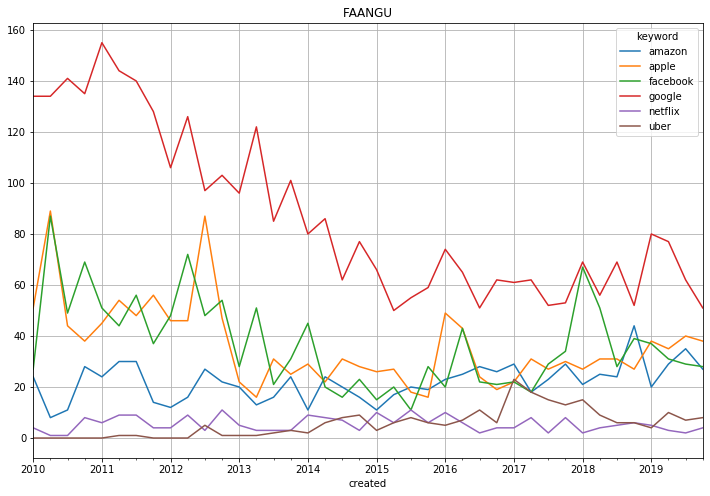

In [28]:
keywords_df \
    [keywords_df.keyword.isin(['facebook', 'apple', 'amazon', 'netflix', 'google', 'uber'])] \
    .groupby(['created', 'keyword']) \
    .count()['rank'] \
    .unstack() \
    .fillna(0) \
    .resample('Q') \
    .sum() \
    .plot(title='FAANGU', grid=True, figsize=(12, 8))

## Export

In [29]:
uniq_df = keywords_df \
    .groupby('keyword') \
    .count()['rank'] \
    .reset_index() \
    .sort_values('rank', ascending=False) \
    .reset_index()
uniq_df = uniq_df[uniq_df['rank'] >= 10]

In [30]:
uniq_df \
    [['keyword', 'rank']] \
    .to_json('public/dataset/hn/keywords.json', orient='values')

In [142]:
for size in ('D', 'W', 'M', 'Q', 'Y'):
    ts_df = keywords_df \
        [keywords_df.keyword.isin(uniq_df.keyword)] \
        .groupby(['created', 'keyword']) \
        .count()['rank'] \
        .unstack() \
        .fillna(0) \
        .resample(size) \
        .sum()
    
    ts_df \
        .index \
        .to_series() \
        .to_json(f'public/dataset/hn/ts/{size}_index.json', date_format='iso', orient='values')
    
    for keyword in uniq_df.keyword.to_list():    
        filename = urllib.parse.quote_plus(keyword.encode("utf-8"))
        ts_df \
            [keyword] \
            .to_json(f'public/dataset/hn/ts/{size}/{filename}.json', orient='values')

In [297]:
# TODO: make it not hardcoded!!!

json.dump({
    'FAANG': ['facebook', 'apple', 'amazon', 'netflix', 'google'],
    'OS': ['windows', 'linux', 'macos', 'ubuntu'],
    'Mobile': ['ios', 'android'],
    'PL': ['java', 'c', 'python', 'javascript', 'php', 'swift', 'ruby', 'go', 'perl'],
}, open('public/dataset/hn/presets.json', 'w'))